In [1]:
# Model 2: https://github.com/npa02012/kaggle_riiid/blob/6d0630cc1968abfb98ebfc83f5ee77a5bf9c60c0/script_loop.ipynb
# N_TRAIN_ROW_TOTAL = 101230332
# https://www.kaggle.com/spacelx/2020-r3id-clustering-question-tags/ (Version 5)
# Decide whether or not running on Kaggle
import os
KAGGLE_RUN = True
if os.path.isdir('/home/ubuntu'):
    KAGGLE_RUN = False
    
if KAGGLE_RUN:
    model_name = 'modelloop6/modelloop6.txt'
else:
    model_name = 'modelloop6.txt'

import sys
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import lightgbm as lgb
import datatable as dt

if not KAGGLE_RUN:
    sys.path.insert(0, './input')
    import local_work
    
import riiideducation

# Boto3 Setup and Download Files
if not KAGGLE_RUN:
    local_work = local_work.local_work()
    local_work.download_riiid_files()

import random
import os

# Random seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
# Funcion for user stats with loops
def add_features(df, features_dicts, KAGGLE_RUN, is_inference):
    include_tasks = True
    # -----------------------------------------------------------------------
    # Get feature dicts
    d_answered_correctly_u_count = features_dicts['d_answered_correctly_u_count']
    d_answered_correctly_u_sum = features_dicts['d_answered_correctly_u_sum']
    d_answered_correctly_prev5_u = features_dicts['d_answered_correctly_prev5_u']
    d_elapsed_time_u_sum = features_dicts['d_elapsed_time_u_sum']
    d_explanation_u_sum = features_dicts['d_explanation_u_sum']
    d_answered_correctly_q_count = features_dicts['d_answered_correctly_q_count']
    d_answered_correctly_q_sum = features_dicts['d_answered_correctly_q_sum']
    d_elapsed_time_q_sum = features_dicts['d_elapsed_time_q_sum']
    d_explanation_ac_q_count = features_dicts['d_explanation_ac_q_count']
    d_answered_correctly_uq = features_dicts['d_answered_correctly_uq']
    d_timestamp_u = features_dicts['d_timestamp_u']
    d_timestamp_u_incorrect = features_dicts['d_timestamp_u_incorrect']
    d_answered_correctly_up_sum = features_dicts['d_answered_correctly_up_sum']
    d_answered_correctly_up_count = features_dicts['d_answered_correctly_up_count']
    d_answered_correctly_uc_count = features_dicts['d_answered_correctly_uc_count']
    d_answered_correctly_uc_sum = features_dicts['d_answered_correctly_uc_sum']
    d_answered_correctly_ut_count = features_dicts['d_answered_correctly_ut_count']
    d_answered_correctly_ut_sum = features_dicts['d_answered_correctly_ut_sum']
    d_lectures_u_count = features_dicts['d_lectures_u_count']
    
    
    # -----------------------------------------------------------------------
    # Client features
    answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
    answered_correctly_prev5_u_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
    explanation_u_avg = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_2 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_3 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_incorrect_recency = np.zeros(len(df), dtype = np.float32)
    
    lectures_u_count = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    # Question features
    answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
    explanation_q_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Question
    answered_correctly_uq_count = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    # User Part
    answered_correctly_up_count = np.zeros(len(df), dtype = np.int32)
    answered_correctly_up_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Community
    answered_correctly_uc_count = np.zeros(len(df), dtype = np.int32)
    answered_correctly_uc_avg = np.zeros(len(df), dtype = np.float32)    
    # -----------------------------------------------------------------------
    # User Tags
    answered_correctly_ut_cum_count = np.zeros(len(df), dtype = np.int32)
    answered_correctly_ut_cum_sum = np.zeros(len(df), dtype = np.int)
    answered_correctly_ut_cum_avg = np.zeros(len(df), dtype = np.float)
    # -----------------------------------------------------------------------
        
    DF_NROW = df.shape[0]
    for num, row in enumerate(df[['user_id'
                                  ,'answered_correctly'
                                  ,'content_id'
                                  ,'prior_question_elapsed_time'
                                  ,'prior_question_had_explanation'
                                  ,'timestamp'
                                  ,'part'
                                  ,'community'
                                  ,'tags' 
                                  ,'content_type_id' # 9
                                 ]].values):
        
        if DF_NROW > 1000000 and not KAGGLE_RUN:
            if num % 500000 == 0:
                print('Progress: ' + str(round(num/DF_NROW, 3)))
                
        if row[9] == 1:
            # Lecture updates
            # ------------------------------------------------------------------
            d_lectures_u_count[row[0]] += 1
            
        else:
            # Client features assignation
            # ------------------------------------------------------------------
            if d_answered_correctly_u_count[row[0]] != 0:
                answered_correctly_u_avg[num] = d_answered_correctly_u_sum[row[0]] /\
                                                    d_answered_correctly_u_count[row[0]]
                elapsed_time_u_avg[num] = d_elapsed_time_u_sum[row[0]] / d_answered_correctly_u_count[row[0]]
                explanation_u_avg[num] = d_explanation_u_sum[row[0]] / d_answered_correctly_u_count[row[0]]
            else:
                answered_correctly_u_avg[num] = np.nan
                elapsed_time_u_avg[num] = np.nan
                explanation_u_avg[num] = np.nan

            if len(d_timestamp_u[row[0]]) == 0:
                timestamp_u_recency_1[num] = np.nan
                timestamp_u_recency_2[num] = np.nan
                timestamp_u_recency_3[num] = np.nan
            elif len(d_timestamp_u[row[0]]) == 1:
                timestamp_u_recency_1[num] = row[5] - d_timestamp_u[row[0]][0]
                timestamp_u_recency_2[num] = np.nan
                timestamp_u_recency_3[num] = np.nan
            elif len(d_timestamp_u[row[0]]) == 2:
                timestamp_u_recency_1[num] = row[5] - d_timestamp_u[row[0]][1]
                timestamp_u_recency_2[num] = row[5] - d_timestamp_u[row[0]][0]
                timestamp_u_recency_3[num] = np.nan
            elif len(d_timestamp_u[row[0]]) == 3:
                timestamp_u_recency_1[num] = row[5] - d_timestamp_u[row[0]][2]
                timestamp_u_recency_2[num] = row[5] - d_timestamp_u[row[0]][1]
                timestamp_u_recency_3[num] = row[5] - d_timestamp_u[row[0]][0]

            if len(d_timestamp_u_incorrect[row[0]]) == 0:
                timestamp_u_incorrect_recency[num] = np.nan
            else:
                timestamp_u_incorrect_recency[num] = row[5] - d_timestamp_u_incorrect[row[0]][0]

            if len(d_answered_correctly_prev5_u[row[0]]) == 0:
                answered_correctly_prev5_u_avg[num] = np.nan
            else:
                answered_correctly_prev5_u_avg[num] = sum(d_answered_correctly_prev5_u[row[0]])/\
                                                        len(d_answered_correctly_prev5_u[row[0]])
                
            # Lecture assignation
            lectures_u_count[num] = d_lectures_u_count[row[0]]

            # ------------------------------------------------------------------
            # Question features assignation
            if d_answered_correctly_q_count[row[2]] != 0:
                answered_correctly_q_avg[num] = d_answered_correctly_q_sum[row[2]] / d_answered_correctly_q_count[row[2]]
                elapsed_time_q_avg[num] = d_elapsed_time_q_sum[row[2]] / d_answered_correctly_q_count[row[2]]
                explanation_q_avg[num] = d_explanation_ac_q_count[row[2]] / d_answered_correctly_q_count[row[2]]
            else:
                answered_correctly_q_avg[num] = np.nan
                elapsed_time_q_avg[num] = np.nan
                explanation_q_avg[num] = np.nan

            # ------------------------------------------------------------------
            # Client Question assignation
            answered_correctly_uq_count[num] = d_answered_correctly_uq[row[0]][row[2]]

            # ------------------------------------------------------------------
            # Client Part assignation
            answered_correctly_up_count[num] = d_answered_correctly_up_count[row[0]][row[6]]
            if d_answered_correctly_up_count[row[0]][row[6]] == 0:
                answered_correctly_up_avg[num] = np.nan
            else:
                answered_correctly_up_avg[num] = d_answered_correctly_up_sum[row[0]][row[6]] /\
                                                    d_answered_correctly_up_count[row[0]][row[6]]
            # ------------------------------------------------------------------
            # Client Community assignation
            answered_correctly_uc_count[num] = d_answered_correctly_uc_count[row[0]][row[7]]
            if d_answered_correctly_uc_count[row[0]][row[7]] == 0:
                answered_correctly_uc_avg[num] = np.nan
            else:
                answered_correctly_uc_avg[num] = d_answered_correctly_uc_sum[row[0]][row[7]] /\
                                                    d_answered_correctly_uc_count[row[0]][row[7]]  

            # ------------------------------------------------------------------
            # Client Tag assignation
            if include_tasks:
                for t in row[8]:
                    answered_correctly_ut_cum_count[num] += d_answered_correctly_ut_count[row[0]][t]
                    answered_correctly_ut_cum_sum[num] += d_answered_correctly_ut_sum[row[0]][t]
                    
                if answered_correctly_ut_cum_count[num] == 0:
                    answered_correctly_ut_cum_avg[num] = np.nan
                else:
                    answered_correctly_ut_cum_avg[num] = answered_correctly_ut_cum_sum[num] /\
                                                            answered_correctly_ut_cum_count[num]                 

            # ------------------------------------------------------------------
            # ------------------------------------------------------------------
            # Client features updates
            d_answered_correctly_u_count[row[0]] += 1
            d_elapsed_time_u_sum[row[0]] += row[3]
            d_explanation_u_sum[row[0]] += int(row[4])
            if len(d_timestamp_u[row[0]]) == 3:
                d_timestamp_u[row[0]].pop(0)
            d_timestamp_u[row[0]].append(row[5])
            # ------------------------------------------------------------------
            # Question features updates
            d_answered_correctly_q_count[row[2]] += 1
            d_elapsed_time_q_sum[row[2]] += row[3]
            d_explanation_ac_q_count[row[2]] += int(row[4])
            # ------------------------------------------------------------------
            # Client Question updates
            d_answered_correctly_uq[row[0]][row[2]] += 1
            # ------------------------------------------------------------------
            # Client Part updates
            d_answered_correctly_up_count[row[0]][row[6]] += 1 
            # ------------------------------------------------------------------
            # Client Community updates
            d_answered_correctly_uc_count[row[0]][row[7]] += 1    
            # ------------------------------------------------------------------
            # Client Tag updates
            if include_tasks:
                for t in row[8]:
                    d_answered_correctly_ut_count[row[0]][t] += 1            

            # ------------------------------------------------------------------
            # Flag for training and inference. Note: this is almost identical to update_features()
            if not is_inference:
                # ------------------------------------------------------------------
                # Client features updates
                d_answered_correctly_u_sum[row[0]] += row[1]
                if row[1] == 0:
                    if len(d_timestamp_u_incorrect[row[0]]) == 1:
                        d_timestamp_u_incorrect[row[0]].pop(0)
                    d_timestamp_u_incorrect[row[0]].append(row[5])

                if len(d_answered_correctly_prev5_u[row[0]]) == 5:
                    d_answered_correctly_prev5_u[row[0]].pop(0)
                d_answered_correctly_prev5_u[row[0]].append(row[1])                

                # ------------------------------------------------------------------
                # Question features updates
                d_answered_correctly_q_sum[row[2]] += row[1]

                # ------------------------------------------------------------------
                # Client Part features updates
                d_answered_correctly_up_sum[row[0]][row[6]] += row[1]

                # ------------------------------------------------------------------
                # Client Community features updates
                d_answered_correctly_uc_sum[row[0]][row[7]] += row[1]
                
                # ------------------------------------------------------------------
                # Client Community tag updates                
                if include_tasks:
                    for t in row[8]:
                        d_answered_correctly_ut_sum[row[0]][t] += row[1]                 

                # ------------------------------------------------------------------
             
    # END FOR LOOP
    
    user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg
                            ,'elapsed_time_u_avg': elapsed_time_u_avg
                            ,'explanation_u_avg': explanation_u_avg
                            ,'answered_correctly_q_avg': answered_correctly_q_avg
                            ,'answered_correctly_prev5_u_avg': answered_correctly_prev5_u_avg
                            ,'elapsed_time_q_avg': elapsed_time_q_avg
                            ,'explanation_q_avg': explanation_q_avg
                            ,'answered_correctly_uq_count': answered_correctly_uq_count
                            ,'timestamp_u_recency_1': timestamp_u_recency_1
                            ,'timestamp_u_recency_2': timestamp_u_recency_2
                            ,'timestamp_u_recency_3': timestamp_u_recency_3
                            ,'timestamp_u_incorrect_recency': timestamp_u_incorrect_recency
                            ,'answered_correctly_up_avg' : answered_correctly_up_avg
                            ,'answered_correctly_up_count' : answered_correctly_up_count
                            ,'answered_correctly_uc_avg' : answered_correctly_uc_avg
                            ,'answered_correctly_uc_count' : answered_correctly_uc_count
                            ,'answered_correctly_ut_cum_count' : answered_correctly_ut_cum_count 
                            ,'answered_correctly_ut_cum_avg' : answered_correctly_ut_cum_avg
                            ,'lectures_u_count' : lectures_u_count
                           })
    
    # Only need to concat rows if building a model or inferring
    if (not KAGGLE_RUN) or is_inference:
        df = pd.concat([df, user_df], axis = 1)
        
    # Return
    return df
        
def update_features(df, features_dicts):
    # -----------------------------------------------------------------------
    # Get feature dicts
    d_answered_correctly_u_sum = features_dicts['d_answered_correctly_u_sum']
    d_answered_correctly_q_sum = features_dicts['d_answered_correctly_q_sum']
    d_timestamp_u_incorrect = features_dicts['d_timestamp_u_incorrect']
    d_answered_correctly_prev5_u = features_dicts['d_answered_correctly_prev5_u']
    d_answered_correctly_up_sum = features_dicts['d_answered_correctly_up_sum']
    d_answered_correctly_uc_sum = features_dicts['d_answered_correctly_uc_sum']
    d_answered_correctly_ut_sum = features_dicts['d_answered_correctly_ut_sum']
    
    for row in df[['user_id'
                   ,'answered_correctly'
                   ,'content_id'
                   ,'content_type_id'
                   ,'timestamp'
                   ,'part'
                   ,'community'
                   ,'tags' # 7
                  ]].values:
        if row[3] == 0:
            # ------------------------------------------------------------------
            # Client features updates
            d_answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(d_timestamp_u_incorrect[row[0]]) == 1:
                    d_timestamp_u_incorrect[row[0]].pop(0)
                d_timestamp_u_incorrect[row[0]].append(row[4])
                
            if len(d_answered_correctly_prev5_u[row[0]]) == 5:
                d_answered_correctly_prev5_u[row[0]].pop(0)
            d_answered_correctly_prev5_u[row[0]].append(row[1])                   
            # ------------------------------------------------------------------
            # Question features updates
            d_answered_correctly_q_sum[row[2]] += row[1]
            
            # ------------------------------------------------------------------
            # Client Part features updates
            d_answered_correctly_up_sum[row[0]][row[5]] += row[1]
            
            # ------------------------------------------------------------------
            # Client Community features updates
            d_answered_correctly_uc_sum[row[0]][row[6]] += row[1]
            
            # ------------------------------------------------------------------
            # Client Community tag updates  
            include_tasks = True
            if include_tasks:
                for t in row[7]:
                    d_answered_correctly_ut_sum[row[0]][t] += row[1]               

def read_and_preprocess(KAGGLE_RUN):

    # Make feature_dicts dictionary for easy passing between functions
    features_dicts = {
        # Client dictionaries
        'd_answered_correctly_u_count': defaultdict(int)
        ,'d_answered_correctly_u_sum': defaultdict(int)
        ,'d_answered_correctly_prev5_u': defaultdict(list)
        ,'d_elapsed_time_u_sum': defaultdict(int)
        ,'d_explanation_u_sum': defaultdict(int)
        ,'d_timestamp_u': defaultdict(list)
        ,'d_timestamp_u_incorrect': defaultdict(list)
        ,'d_lectures_u_count': defaultdict(int)
        
        # Question Dictionaries
        ,'d_answered_correctly_q_count': defaultdict(int)
        ,'d_answered_correctly_q_sum': defaultdict(int)
        ,'d_elapsed_time_q_sum': defaultdict(int)
        ,'d_explanation_ac_q_count': defaultdict(int)
        
        # Client Question dictionary (how many times has the client seen the question)
        ,'d_answered_correctly_uq': defaultdict(lambda: defaultdict(int))
        
        # Client Part dictionary
        ,'d_answered_correctly_up_count': defaultdict(lambda: defaultdict(int))
        ,'d_answered_correctly_up_sum': defaultdict(lambda: defaultdict(int))
        
        # Client Community Dictionary
        ,'d_answered_correctly_uc_count': defaultdict(lambda: defaultdict(int))
        ,'d_answered_correctly_uc_sum' : defaultdict(lambda: defaultdict(int))
        
        # Client Tag Dictionary
        ,'d_answered_correctly_ut_count': defaultdict(lambda: defaultdict(int))
        ,'d_answered_correctly_ut_sum': defaultdict(lambda: defaultdict(int))
    }
    
    # Load questions
    if not KAGGLE_RUN:
        questions_df = local_work.get_questions_data()
        question_cmnts = pd.read_csv('./input/question_cmnts_v5.csv')
    else:   
        questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
        question_cmnts = pd.read_csv('../input/question-cmnts-v5/question_cmnts_v5.csv')
        
    # Add Communities to questions
    question_cmnts.columns = ['question_id', 'community']
    questions_df = questions_df.merge(question_cmnts, on = 'question_id', how = 'left')
    
    # Get tags of questions
    inv_rows = questions_df[questions_df['tags'].apply(type) == float].index
    questions_df.at[inv_rows, 'tags'] = ''
    questions_df['tags'] = questions_df['tags'].apply(lambda x: np.array(x.split()).astype(int))
    questions_df['n_tags'] = questions_df['tags'].str.len()
    questions_df['tag_1'] = questions_df['tags'].map(lambda x: x[0] if len(x) > 0 else np.nan)
    questions_df['tag_2'] = questions_df['tags'].map(lambda x: x[1] if len(x) > 1 else np.nan)
    questions_df['tag_3'] = questions_df['tags'].map(lambda x: x[2] if len(x) > 2 else np.nan)
        
    # Change questions dtypes
    questions_df['part'] = questions_df['part'].astype(np.int32)
    questions_df['bundle_id'] = questions_df['bundle_id'].astype(np.int32)
    questions_df['community'] = questions_df['community'].astype(np.int8)
        
    # Need to load all columns when batching
    train_cols = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
               'task_container_id', 'user_answer', 'answered_correctly',
               'prior_question_elapsed_time', 'prior_question_had_explanation']
    
    # Columns we need
    feld_needed = ['timestamp'
                   ,'user_id'
                   ,'answered_correctly'
                   ,'content_id'
                   ,'content_type_id'
                   ,'prior_question_elapsed_time'
                   ,'prior_question_had_explanation'
                  ]
    total_train_count = 0
    for i in range(11):
        if not KAGGLE_RUN:
            N_TRAIN_ROWS = 60 * 1000000
            train = local_work.get_train_data(feld_needed, nrow=N_TRAIN_ROWS)
            print('Number of rows in train: ' + str(train.shape[0]))
        else:
            train = dt.fread('../input/riiid-test-answer-prediction/train.csv'
                            ,skip_to_line = i * 10000000 + 2
                            ,max_nrows=10000000).to_pandas()
            train.columns = train_cols
            train = train[feld_needed]
        
        total_train_count += train.shape[0]
    
        # Filter by content_type_id to discard lectures
        #train = train.loc[train.content_type_id == 0].reset_index(drop = True)

        # No need for validation set if running on kaggle
        if not KAGGLE_RUN:
            # Make validation set
            # Add entire user histories to validation set
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.07 * tmp.shape[0]))
            valid_full = train.loc[train['user_id'].isin(tmp)]
            train.drop(valid_full.index, inplace=True)

            # Make validation the last 40 of user histories
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.15 * tmp.shape[0]))
            valid_end_40 = train.loc[train['user_id'].isin(tmp)].groupby('user_id').tail(40)
            train.drop(valid_end_40.index, inplace=True)

            # Make validation set the last 100 of user histories
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.15 * tmp.shape[0]))
            valid_end_100 = train.loc[train['user_id'].isin(tmp)].groupby('user_id').tail(100)
            train.drop(valid_end_100.index, inplace=True)   

            # Combine the sets
            print('Joining validation sets')
            valid = valid_full.append([valid_end_40, valid_end_100])
            print('Validation size: ' + str(valid.shape[0]))
            print('Train size: ' + str(train.shape[0]))
        else:
            valid = None

        # Changing dtype to avoid lightgbm error
        train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')

        # Merge with questions dataframe
        q_cols = ['question_id', 'part', 'community', 'correct_answer'
                  ,'tags', 'n_tags', 'tag_1', 'tag_2', 'tag_3']
        train = pd.merge(train, questions_df[q_cols]
                         ,left_on = 'content_id'
                         ,right_on = 'question_id'
                         ,how = 'left')

        if not KAGGLE_RUN:
            valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')
            valid = pd.merge(valid, questions_df[q_cols]
                             ,left_on = 'content_id'
                             ,right_on = 'question_id'
                             ,how = 'left')

        print('Train Feature Calculation Started - ' + str(i))
        train = add_features(train, features_dicts, KAGGLE_RUN = KAGGLE_RUN, is_inference = False)
        
        # Only run once for model buildling
        if not KAGGLE_RUN:
            break
    
    print('Number of training rows read: ' + str(total_train_count))
    
    # Free up space
    if KAGGLE_RUN:
        del train
        train = None
    
    # Add features for validation set
    if not KAGGLE_RUN:
        print('Valid Feature Calculation Started')
        valid = add_features(valid, features_dicts, KAGGLE_RUN = KAGGLE_RUN, is_inference = False)
    gc.collect()
    
    # Filter by content_type_id to discard lectures for modeling
    if not KAGGLE_RUN:
        train = train.loc[train.content_type_id == 0].reset_index(drop = True) 
        valid = valid.loc[valid.content_type_id == 0].reset_index(drop = True) 
    
    return train, valid, questions_df, features_dicts

# Function for training and evaluation
def train_and_evaluate(train, valid, KAGGLE_RUN, model_name):
    
    TARGET = 'answered_correctly'
    
    FEATURES = [
                'prior_question_elapsed_time'
                ,'prior_question_had_explanation'
                ,'part'
                ,'community'#
                ,'answered_correctly_u_avg'
                ,'answered_correctly_prev5_u_avg'
                ,'elapsed_time_u_avg'
                ,'explanation_u_avg'
                ,'answered_correctly_q_avg'
                ,'elapsed_time_q_avg'
                ,'explanation_q_avg'
                ,'answered_correctly_uq_count'
                ,'timestamp_u_recency_1'
                ,'timestamp_u_recency_2'
                ,'timestamp_u_recency_3'
                ,'timestamp_u_incorrect_recency'
                ,'answered_correctly_up_avg'
                ,'answered_correctly_up_count'
                ,'answered_correctly_uc_avg'#
                ,'answered_correctly_uc_count'#
                ,'answered_correctly_ut_cum_count'
                ,'answered_correctly_ut_cum_avg'
                ,'n_tags'#
                ,'lectures_u_count'#
                ,'tag_1'
                ,'tag_2'
                ,'tag_3'
                ,'correct_answer'
               ]
    
    if not KAGGLE_RUN:
        print(f'Traning with {train.shape[0]} rows and {len(FEATURES)} features')    
        d_train = lgb.Dataset(train[FEATURES], label=train[TARGET])
        d_valid = lgb.Dataset(valid[FEATURES], label=valid[TARGET])

        params = {'objective': 'binary', 
                  'seed': SEED,
                  'metric': 'auc',
                  'learning_rate': .1,
                  'num_leaves': 220,
                  'feature_fraction': .8,
                  'bagging_fraction': .8,
                  'bagging_freq' : 10,
                  'min_data_in_leaf' : 50,
                  'max_depth' : 12
                 }
        if train.shape[0] < 2000000:
            print('Small data parameters set.')
            params = {'objective': 'binary', 
                      'seed': SEED,
                      'metric': 'auc',
                      'learning_rate': .1,
                      'num_leaves': 100,
                      'feature_fraction': .8,
                      'bagging_fraction': .8,
                      'bagging_freq' : 10,
                      'min_data_in_leaf' : 50,
                      'max_depth' : 12
                     }        

        if True:
            model = lgb.train(
                            params = params,
                            train_set = d_train,
                            num_boost_round = 10000,
                            valid_sets = [d_train, d_valid],
                            early_stopping_rounds = 25,
                            verbose_eval = 100
                            )
            model.save_model(f'./output/' + model_name)
            lgb.plot_importance(model, importance_type='gain')
            lgb.plot_importance(model, importance_type='split')
        else:
            model = lgb.Booster(model_file='./output/' + 'modelloop4.txt')#model_name)
            lgb.plot_importance(model, importance_type='gain')
    else:
        model = lgb.Booster(model_file='/kaggle/input/' + model_name)

    return TARGET, FEATURES, model

# Using time series api that simulates production predictions
def inference(TARGET, FEATURES, model, questions_df, features_dicts):
    
    # Get api iterator and predictor
    env = riiideducation.make_env()
    iter_test = env.iter_test()
    set_predict = env.predict
    
    previous_test_df = None
    for (test_df, sample_prediction_df) in iter_test:
        # Attach question information
        q_cols = ['question_id', 'part', 'community', 'correct_answer'
                  ,'tags', 'n_tags', 'tag_1', 'tag_2', 'tag_3']
        test_df = pd.merge(test_df, questions_df[q_cols]
                           ,left_on = 'content_id'
                           ,right_on = 'question_id'
                           ,how = 'left')
        # Update historical values
        if previous_test_df is not None:
            previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
            update_features(previous_test_df, features_dicts)
        # Continue
        previous_test_df = test_df.copy()
        test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop = True)
        test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
        test_df[TARGET] = 0
        test_df = add_features(test_df, features_dicts, KAGGLE_RUN = KAGGLE_RUN, is_inference = True)
        test_df[TARGET] =  model.predict(test_df[FEATURES])
        set_predict(test_df[['row_id', TARGET]])
        
    print('Job Done')

In [3]:
import time
s = time.time()
train, valid, questions_df, features_dicts = read_and_preprocess(KAGGLE_RUN)
print(round(time.time() - s, 2))

Number of rows in train: 60000000
Joining validation sets
Validation size: 6747611
Train size: 53252389
Train Feature Calculation Started - 0
Progress: 0.0
Progress: 0.009
Progress: 0.019
Progress: 0.028
Progress: 0.038
Progress: 0.047
Progress: 0.056
Progress: 0.066
Progress: 0.075
Progress: 0.085
Progress: 0.094
Progress: 0.103
Progress: 0.113
Progress: 0.122
Progress: 0.131
Progress: 0.141
Progress: 0.15
Progress: 0.16
Progress: 0.169
Progress: 0.178
Progress: 0.188
Progress: 0.197
Progress: 0.207
Progress: 0.216
Progress: 0.225
Progress: 0.235
Progress: 0.244
Progress: 0.254
Progress: 0.263
Progress: 0.272
Progress: 0.282
Progress: 0.291
Progress: 0.3
Progress: 0.31
Progress: 0.319
Progress: 0.329
Progress: 0.338
Progress: 0.347
Progress: 0.357
Progress: 0.366
Progress: 0.376
Progress: 0.385
Progress: 0.394
Progress: 0.404
Progress: 0.413
Progress: 0.423
Progress: 0.432
Progress: 0.441
Progress: 0.451
Progress: 0.46
Progress: 0.469
Progress: 0.479
Progress: 0.488
Progress: 0.498
Pr

Traning with 52209902 rows and 28 features
[LightGBM] [Info] Number of positive: 34509343, number of negative: 17700559
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.650720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 52209902, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660973 -> initscore=0.667634
[LightGBM] [Info] Start training from score 0.667634
Training until validation scores don't improve for 25 rounds
[100]	training's auc: 0.776803	valid_1's auc: 0.777441
[200]	training's auc: 0.77955	valid_1's auc: 0.779686
[300]	training's auc: 0.780919	valid_1's auc: 0.780619
[400]	training's auc: 0.781881	valid_1's auc: 0.781184
[500]	training's auc: 0.782703	valid_1's auc: 0.781605
[600]	training's auc: 0.78336	valid_1's auc: 0.781873


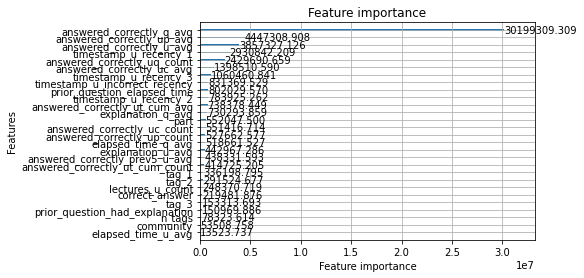

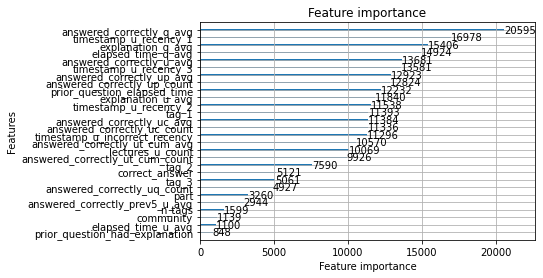

In [4]:
TARGET, FEATURES, model = train_and_evaluate(train, valid, KAGGLE_RUN, model_name)

In [7]:
inference(TARGET, FEATURES, model, questions_df, features_dicts)